### Time Signal을 input으로 넣고 Time+Power를 Loss로 설정
#### Scaling

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../../tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Train_Loss_Plot
from Scaling import time_scaling, time_inv_scaling

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


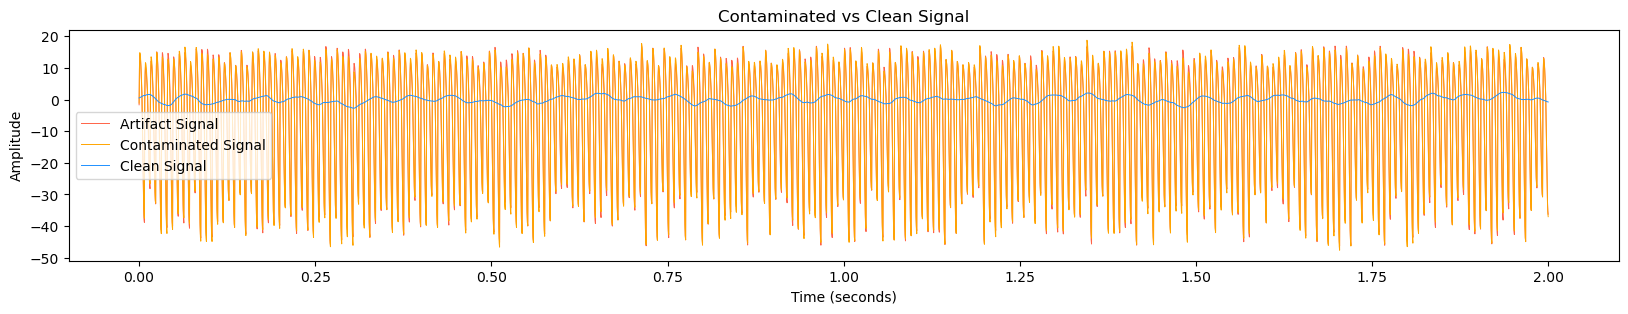

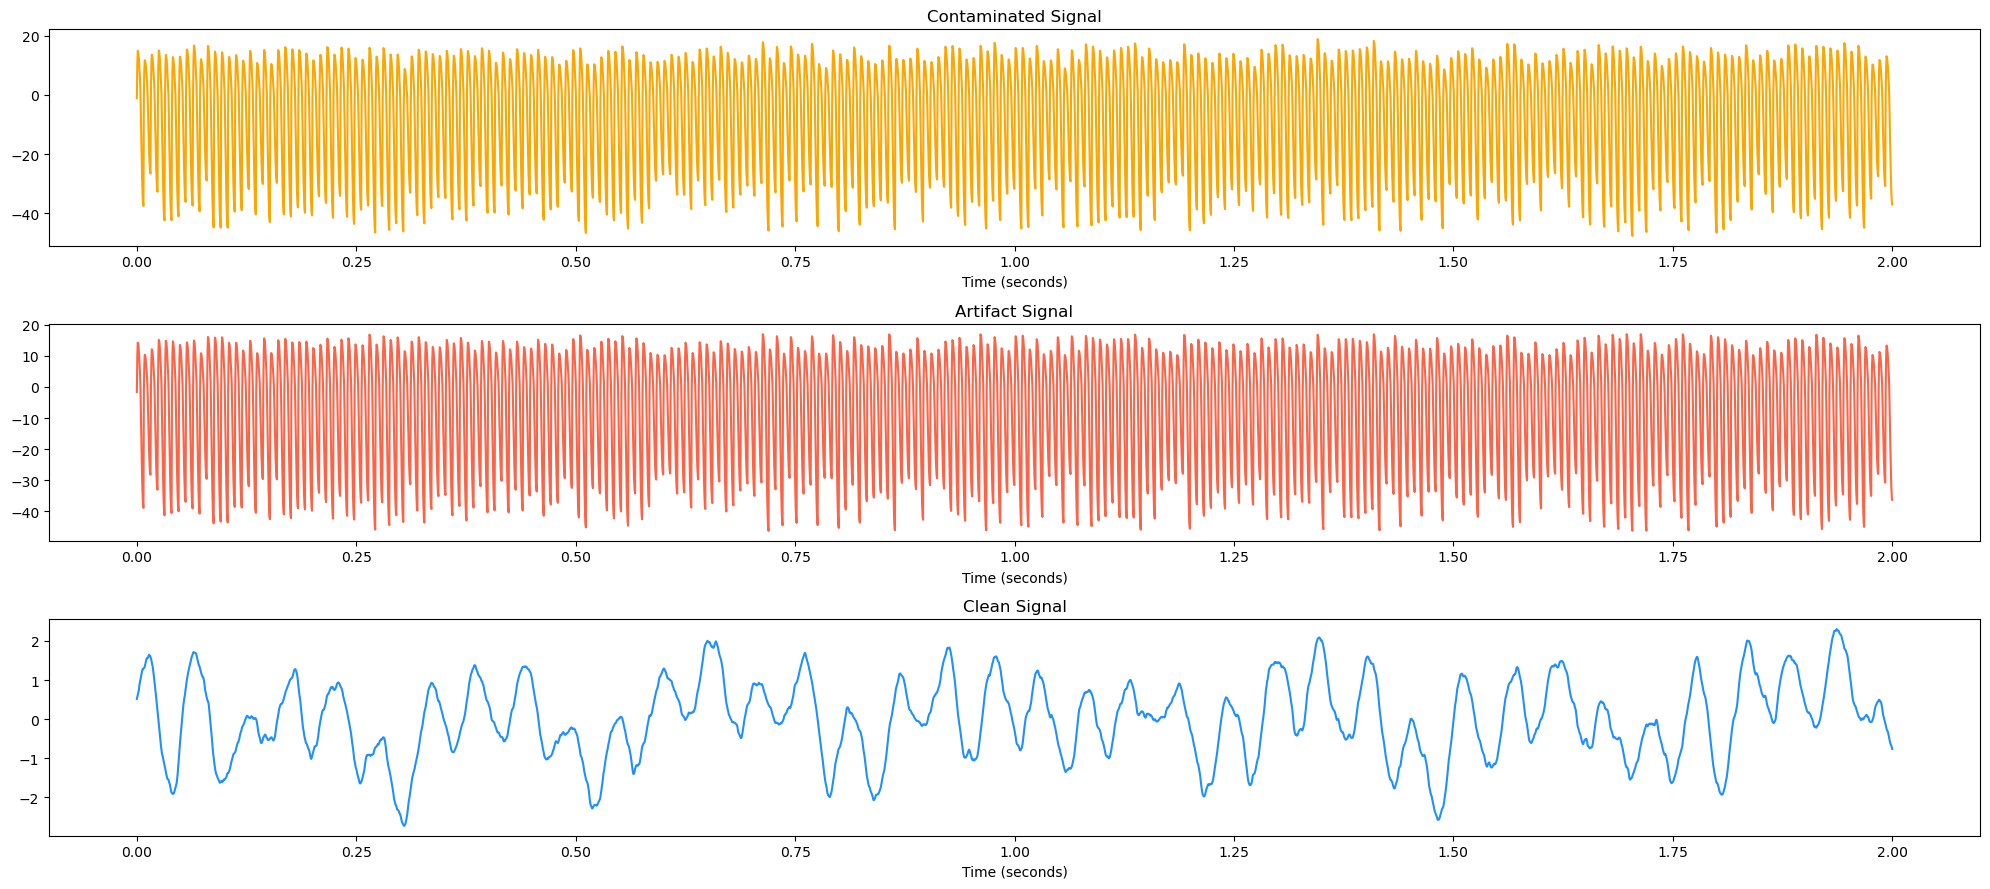

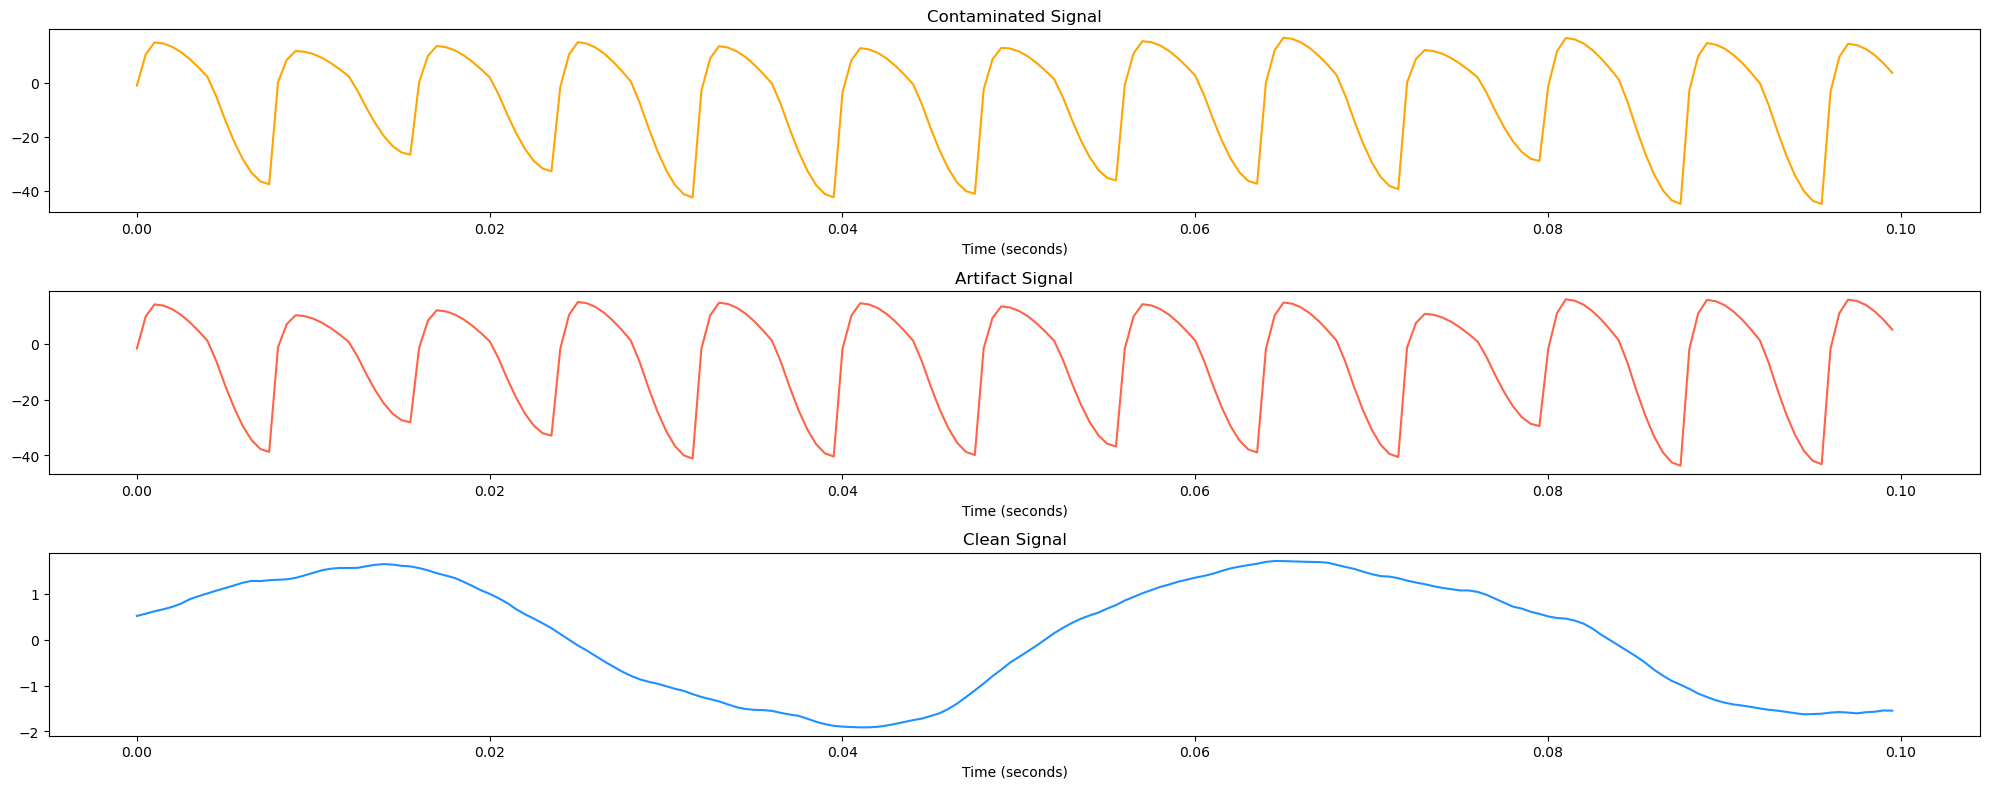

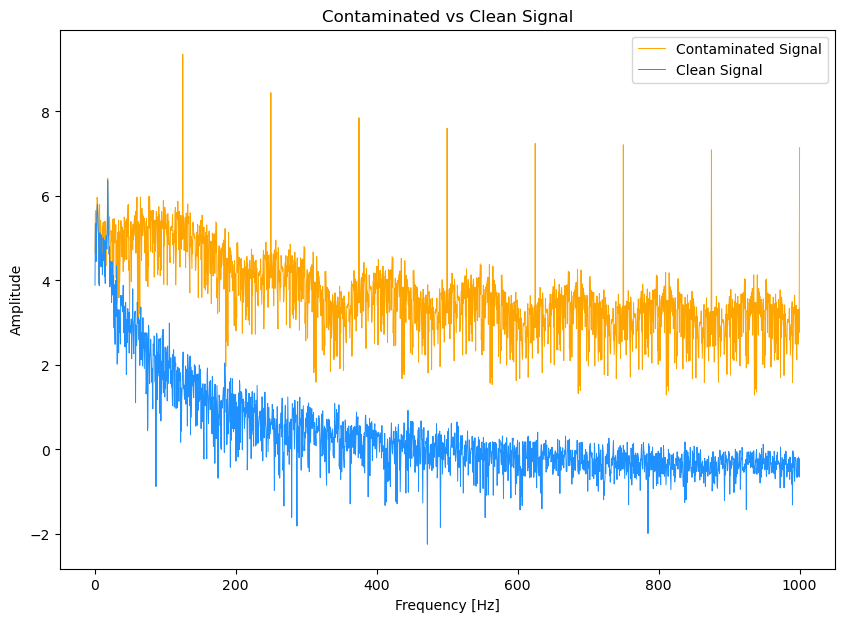

In [2]:
# 데이터 load & plot
datapath='../../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [4]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (MLP는 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000, 1)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000, 1)
-----------------------------


In [5]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=1)
        self.drop = nn.Dropout(0.25)
        self.gelu = nn.GELU()

    def forward(self, input_data): # x : B x T x 1
        x = self.gelu(self.fc1(input_data)) # x : B x T x 256
        x = self.drop(x)
        x = self.gelu(self.fc2(x)) # x : B x T x 128
        x = self.drop(x)
        x = self.gelu(self.fc3(x)) # x : B x T x 64
        x = self.drop(x)
        x = self.fc4(x) # x : B x T x 1 -> x : B x T
        return x

model = MLP().to(device)
print(model)

MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)


In [6]:
# 손실 함수 정의
class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y, y_pred_spectro, y_spectro):
        signal_loss = self.mse_loss(y_pred, y)
        spectrogram_loss = self.mse_loss(y_pred_spectro, y_spectro)
        return self.alpha * signal_loss + (1 - self.alpha) * spectrogram_loss

In [7]:
model = MLP().to(device)
print(model)

# 손실 함수와 옵티마이저 정의
alpha=0.99
criterion = LossFunction(alpha=0.99)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse = nn.MSELoss()

MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)


In [8]:
# 모델 훈련
num_epochs = 1000

loss_list = []

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len = y.squeeze().shape
        y1 = y.view(batch_size, -1)
        y_pred1 = y_pred.view(batch_size, -1)
        
        y_fft = torch.fft.rfft(y1, dim=1)
        y_spectro = torch.abs(y_fft)**2
        y_spectro = torch.log1p(y_spectro)

        y_pred_fft = torch.fft.rfft(y_pred1, dim=1)
        y_pred_spectro = torch.abs(y_pred_fft)**2
        y_pred_spectro = torch.log1p(y_pred_spectro)
        
        loss = criterion(y_pred, y, y_pred_spectro, y_spectro)
        y_val_mse = mse(y_pred, y)*alpha
        y_spectro_mse = mse(y_pred_spectro, y_spectro)*(1-alpha)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():6f} | y_val_mse: {y_val_mse:6f} | y_spectro_mse: {y_spectro_mse}')

Epoch [1/1000] | Loss: 0.020679 | y_val_mse: 0.005159 | y_spectro_mse: 0.015520130284130573
Epoch [2/1000] | Loss: 0.016715 | y_val_mse: 0.004183 | y_spectro_mse: 0.012532076798379421
Epoch [3/1000] | Loss: 0.014899 | y_val_mse: 0.003779 | y_spectro_mse: 0.01112001109868288
Epoch [4/1000] | Loss: 0.013918 | y_val_mse: 0.003553 | y_spectro_mse: 0.01036490872502327
Epoch [5/1000] | Loss: 0.013267 | y_val_mse: 0.003364 | y_spectro_mse: 0.009902945719659328
Epoch [6/1000] | Loss: 0.012683 | y_val_mse: 0.003257 | y_spectro_mse: 0.00942633580416441
Epoch [7/1000] | Loss: 0.012196 | y_val_mse: 0.003155 | y_spectro_mse: 0.009041284210979939
Epoch [8/1000] | Loss: 0.011936 | y_val_mse: 0.003086 | y_spectro_mse: 0.00885065272450447
Epoch [9/1000] | Loss: 0.011811 | y_val_mse: 0.003046 | y_spectro_mse: 0.008765042759478092
Epoch [10/1000] | Loss: 0.011611 | y_val_mse: 0.003002 | y_spectro_mse: 0.00860902201384306
Epoch [11/1000] | Loss: 0.011568 | y_val_mse: 0.002971 | y_spectro_mse: 0.0085969185

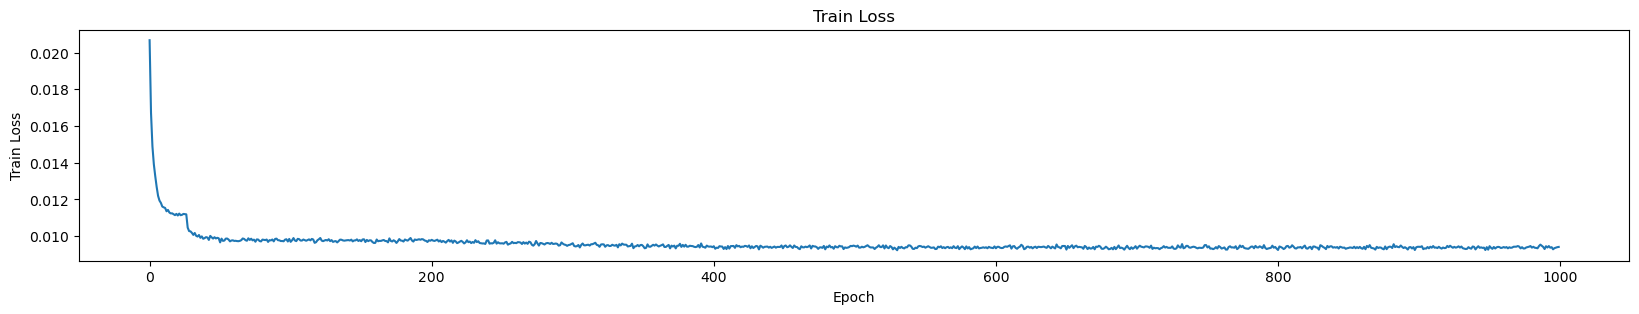

Minimal Train Loss: 0.009230240248143673 [530]



In [9]:
# Train Loss Plot
Train_Loss_Plot(loss_list)

In [12]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len = y.squeeze().shape
        y1 = y.view(batch_size, -1)
        y_pred1 = y_pred.view(batch_size, -1)
        
        y_fft = torch.fft.rfft(y1, dim=1)
        y_spectro = torch.abs(y_fft)**2
        y_spectro = torch.log1p(y_spectro)

        y_pred_fft = torch.fft.rfft(y_pred1, dim=1)
        y_pred_spectro = torch.abs(y_pred_fft)**2
        y_pred_spectro = torch.log1p(y_pred_spectro)

        loss = criterion(y_pred, y, y_pred_spectro, y_spectro)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)
        SACed_spectro = torch.cat((SACed_spectro, y_pred_spectro.cpu()), 0)
        Clean_spectro = torch.cat((Clean_spectro, y_spectro.cpu()), 0)

val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
print(f'Validation Loss: {val_loss.item()}') 

Validation Loss: 0.009316549636423588


<Time Domain Error>
Mean Absolute Error: 0.8164419571493893
Mean Squared Error: 1.0184873661645435


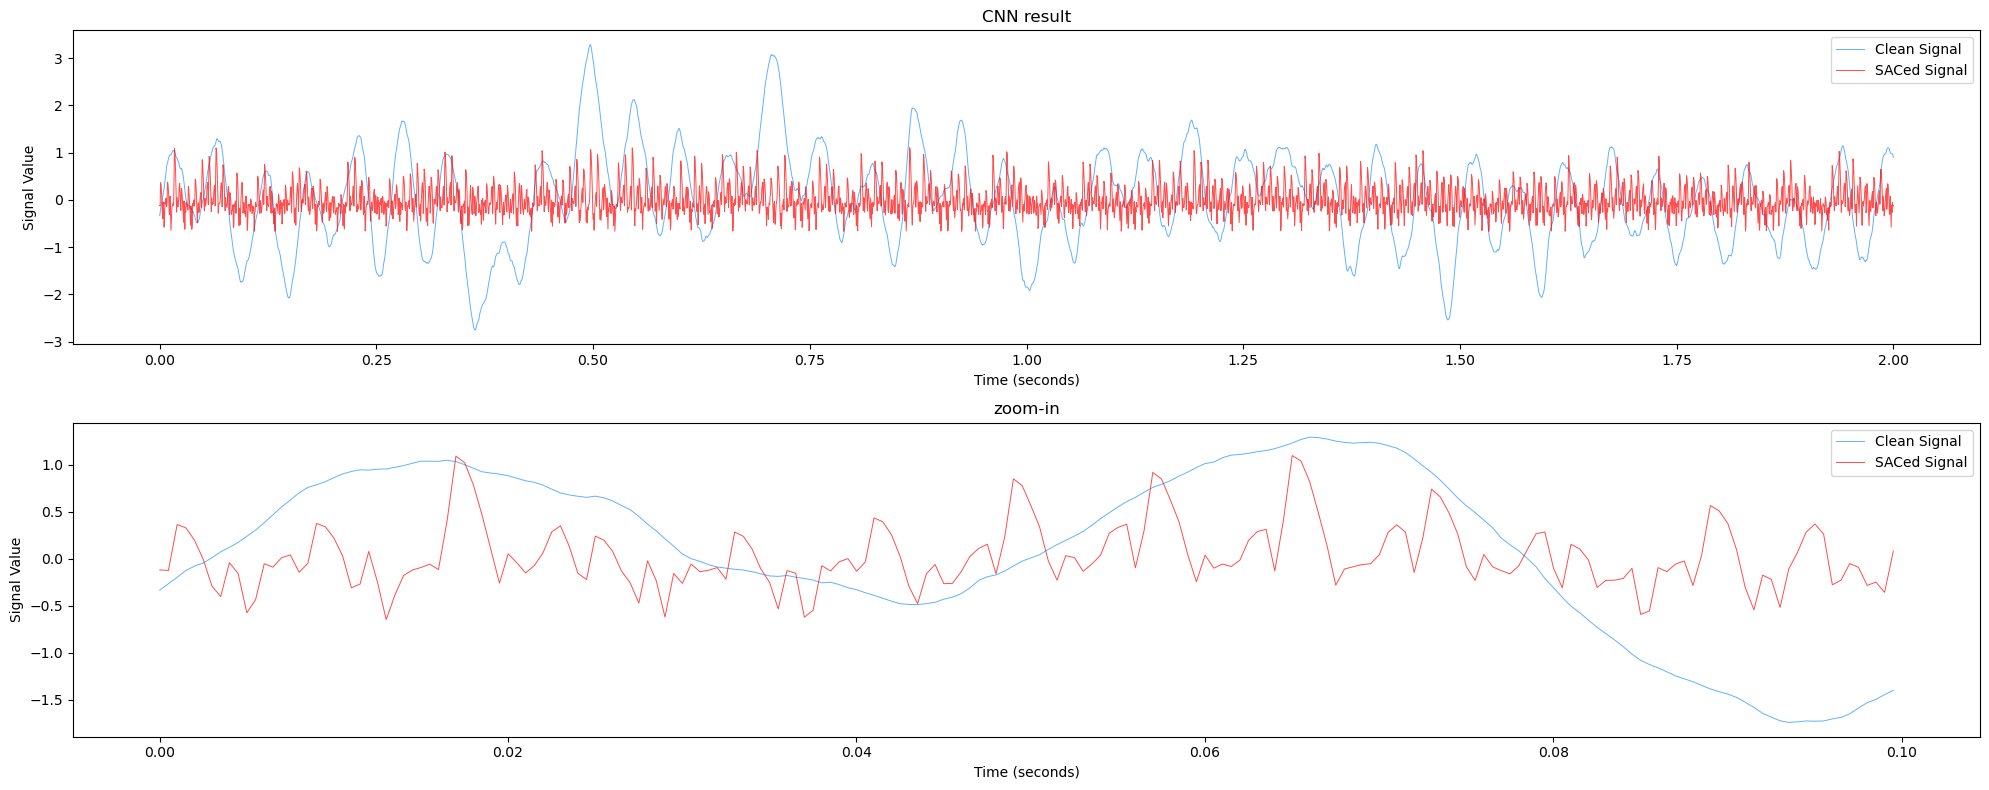

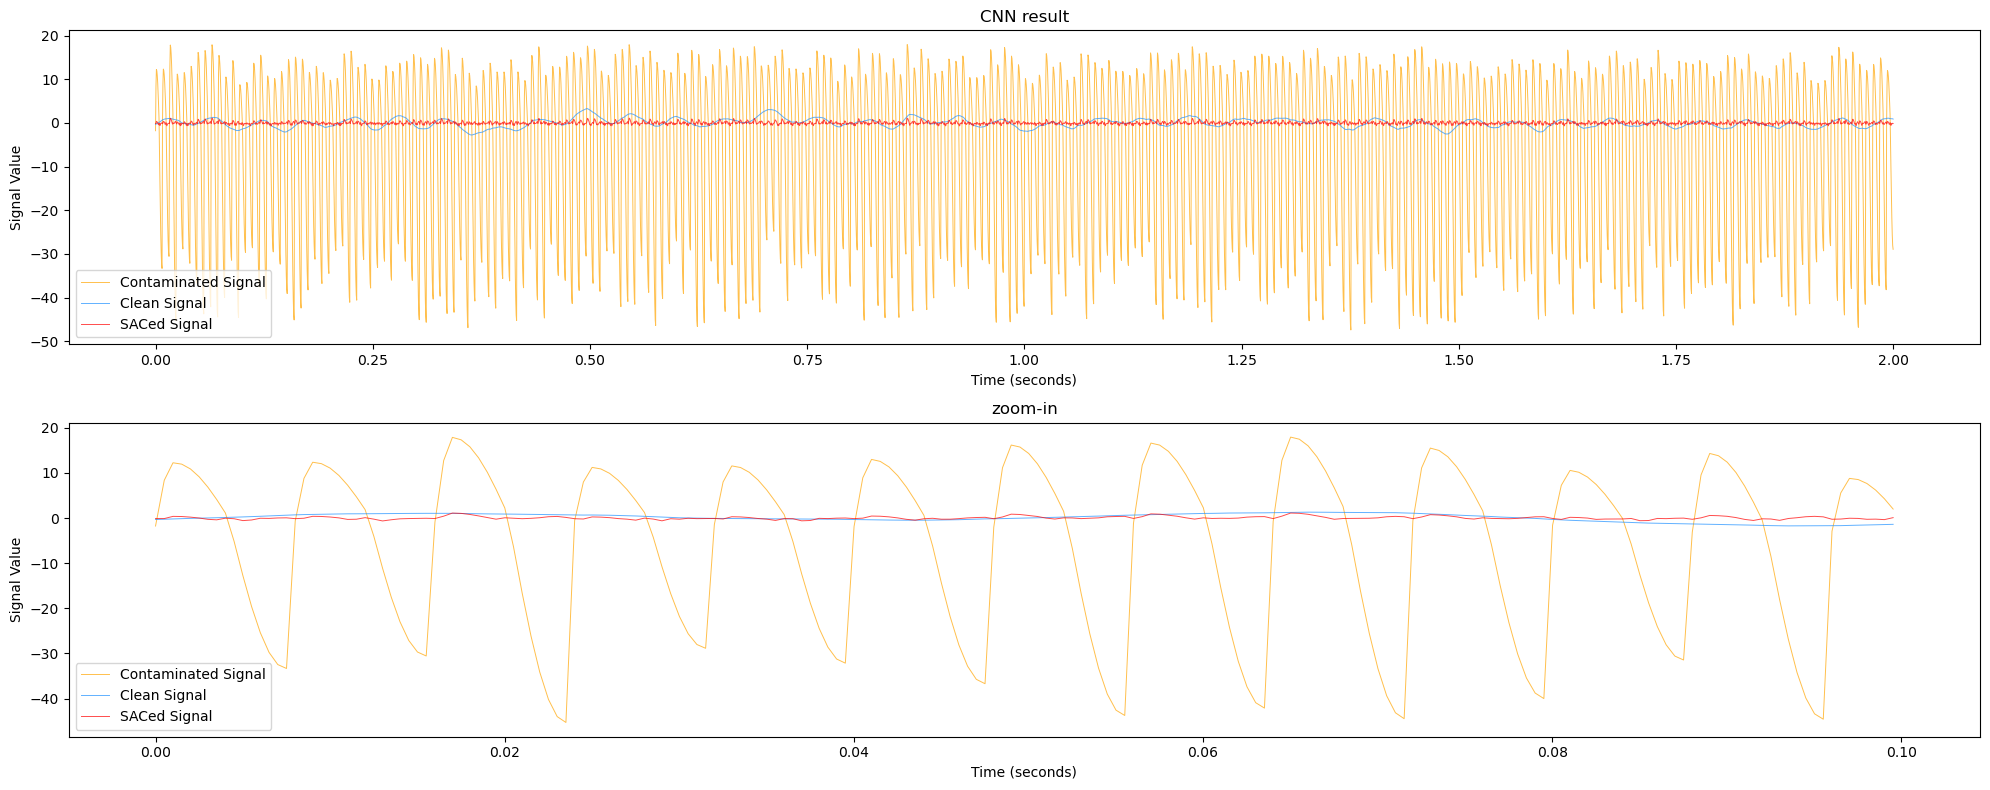

<Frequency Domain Error>
Mean Absolute Error: 1.479827220174263
Mean Squared Error: 2.9765737799432572


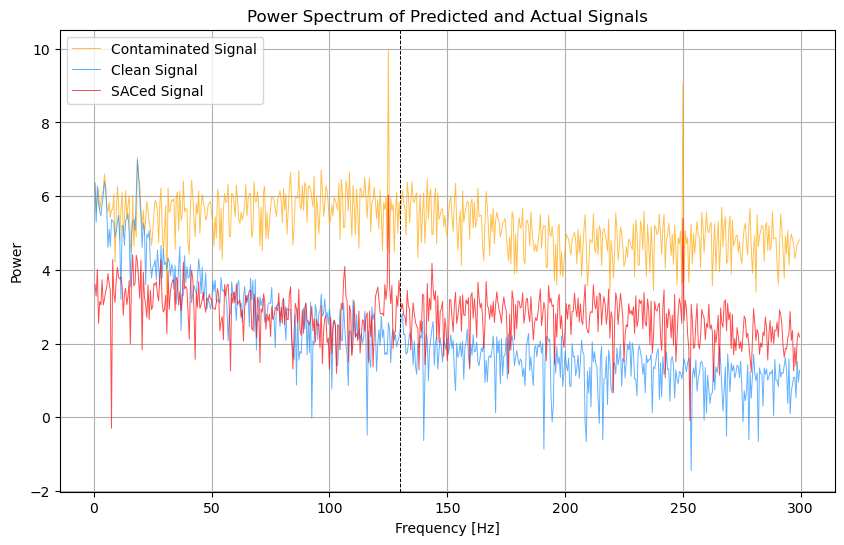

In [11]:
# Inverse Scaling
Cotaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

Result_Plot(Cotaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled)